In [1]:
import numpy as np
import pandas as pd 
import re
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
# import nltk
# import spacy                                       ## pip install -U spacy
# from nltk.tokenize.toktok import ToktokTokenizer
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [2]:
# tokenizer=ToktokTokenizer()
# stopword_list=nltk.corpus.stopwords.words('english')
# stopword_list.remove('no')
# stopword_list.remove('not')

In [3]:
data = pd.read_csv('fbportal_new.csv')
data.head()

,Test Case Description,Label
0,What's the weather like in Chicago?,Weather
1,What is the forecast in Tampa for tomorrow?,Weather
2,What is the weather in Oregon today?,Weather
3,Is it raining in France right now?,Weather
4,Show me the weather in Mexico for next week.,Weather


In [4]:
#df[df['A'].isin([3, 6])]
#data = data[data['Label'].isin(['Weather','Time','Timer','Alarm','Integrity','Corona'])]

In [5]:
data.shape

(827, 2)

In [6]:
data['Label'].value_counts()

Music                  194
Device                 133
Calling                 92
Music_QA                71
Help                    51
Timer                   47
Screen_Reader           39
Weather                 35
Alarm                   30
AR_effect               29
Time                    26
Corona                  21
Integrity               16
Meta                    12
News                    12
Wolfarm_food            10
Assistant_messenger      9
Name: Label, dtype: int64

### Pre-processing

- Converting text into string data type, removing irrelevant words and special characters

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827 entries, 0 to 826
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Test Case Description  827 non-null    object
 1   Label                  827 non-null    object
dtypes: object(2)
memory usage: 13.0+ KB


In [8]:
data['Test Case Description']=data['Test Case Description'].astype(str)



In [9]:
#re.sub(r"Portal is on + portal is not muted Hey Facebook, ","",'Pre-Conditions: Portal is on + portal is not muted Hey Facebook, ""How many carlories does butter have?')
# bannedWord = ['Pre-Conditions: Portal is on + portal is not muted Hey Facebook', 'Pre-Conditions:']
# toPrint = 'Pre-Conditions: Portal is on + portal is not muted Hey Facebook, ""How many carlories does butter have?'
# print( ' '.join(i for i in toPrint.split(',') if i not in bannedWord))

In [10]:
# def remove_stopwords(text, is_lower_case=False):
#     tokens = tokenizer.tokenize(text)
#     tokens = [token.strip() for token in tokens]
#     if is_lower_case:
#         filtered_tokens = [token for token in tokens if token not in stopword_list]
#     else:
#         filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
#     filtered_text = ' '.join(filtered_tokens)    
#     return filtered_text
# remove_stopwords("The, and, if are stopwords, computer is not")

In [11]:
def text_cleaner(text):
   
    newString = text.lower()
    newString = re.sub(r"pre-conditions:","",newString)
    newString = re.sub(r"precondition:","",newString)
    newString = re.sub(r"hey","",newString)
    newString = re.sub(r"portal","",newString)
    newString = re.sub(r"hp","",newString)
    newString = re.sub(r"[^a-zA-Z]+", ' ', newString)
    #newString = remove_stopwords(newString)
    return newString
    

In [12]:
#call the function
cleaned_text = []
for t in data['Test Case Description']:
    cleaned_text.append(text_cleaner(t))

In [13]:
data['cleaned_text']=cleaned_text

In [14]:
print('The number of duplicate records are: ',data.duplicated().sum())
# Extract duplicate rows
data.loc[data.duplicated(), :]
### Dropping duplicates
data.drop_duplicates(keep='first', inplace=True)
data.shape

The number of duplicate records are:  87


(740, 3)

In [15]:
data.tail()

,Test Case Description,Label,cleaned_text
821,"\n From Ambient, IE not logged in: ""Hey Portal, join [room name]""\n",Assistant_messenger,from ambient ie not logged in join room name
822,"\n ""Hey Portal, leave [room name for a room that doesn't exist] room""",Assistant_messenger,leave room name for a room that doesn t exist room
823,"\n ""Hey Portal, leave room""",Assistant_messenger,leave room
824,"\n ""Hey Portal, leave room.""",Assistant_messenger,leave room
825,"\n ""Hey Portal, end room.""",Assistant_messenger,end room


### Exploratory Data Analysis

- Filetering out top 100 most common words in the input commands.

In [16]:
words = data['cleaned_text']
allwords = []

for i in words:
    
    allwords += i.split(' ')

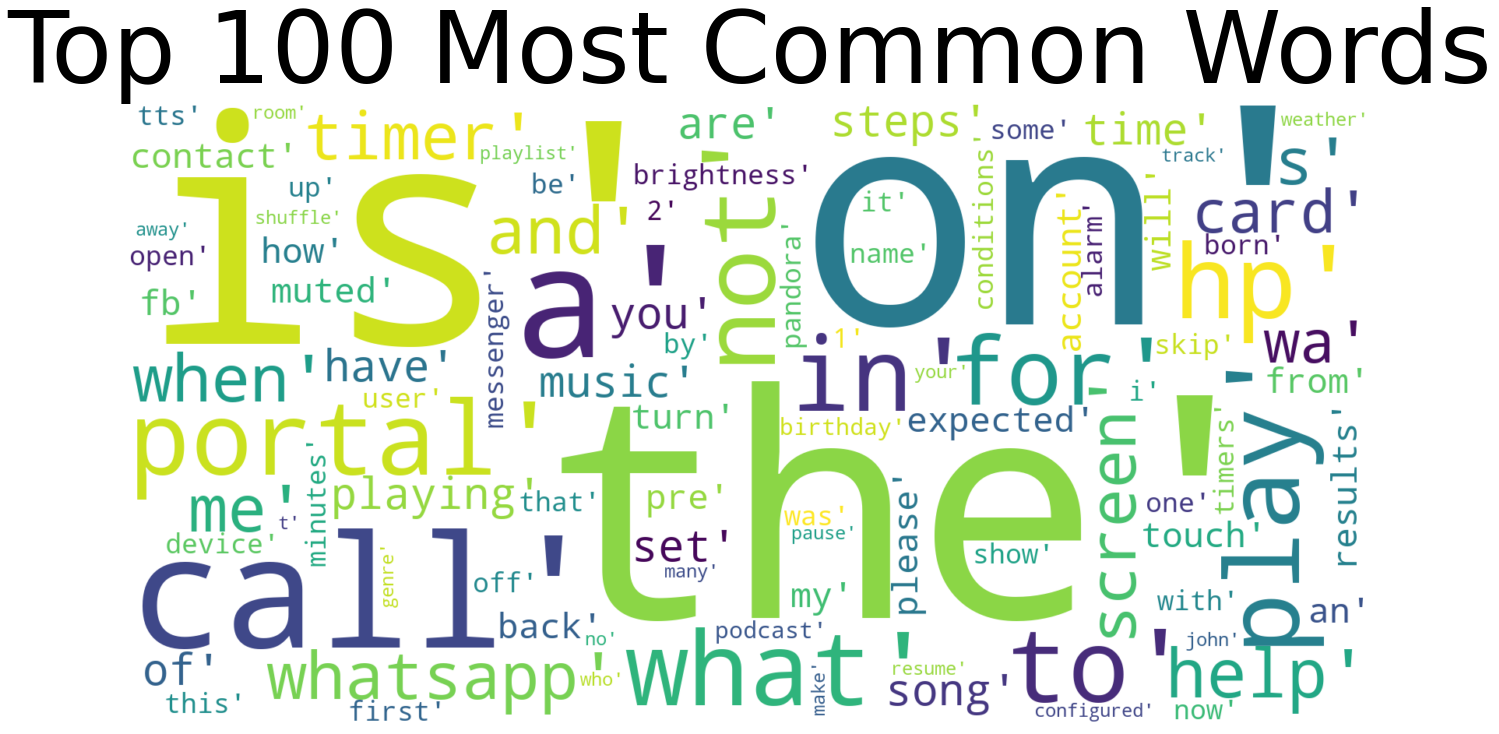

In [14]:
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

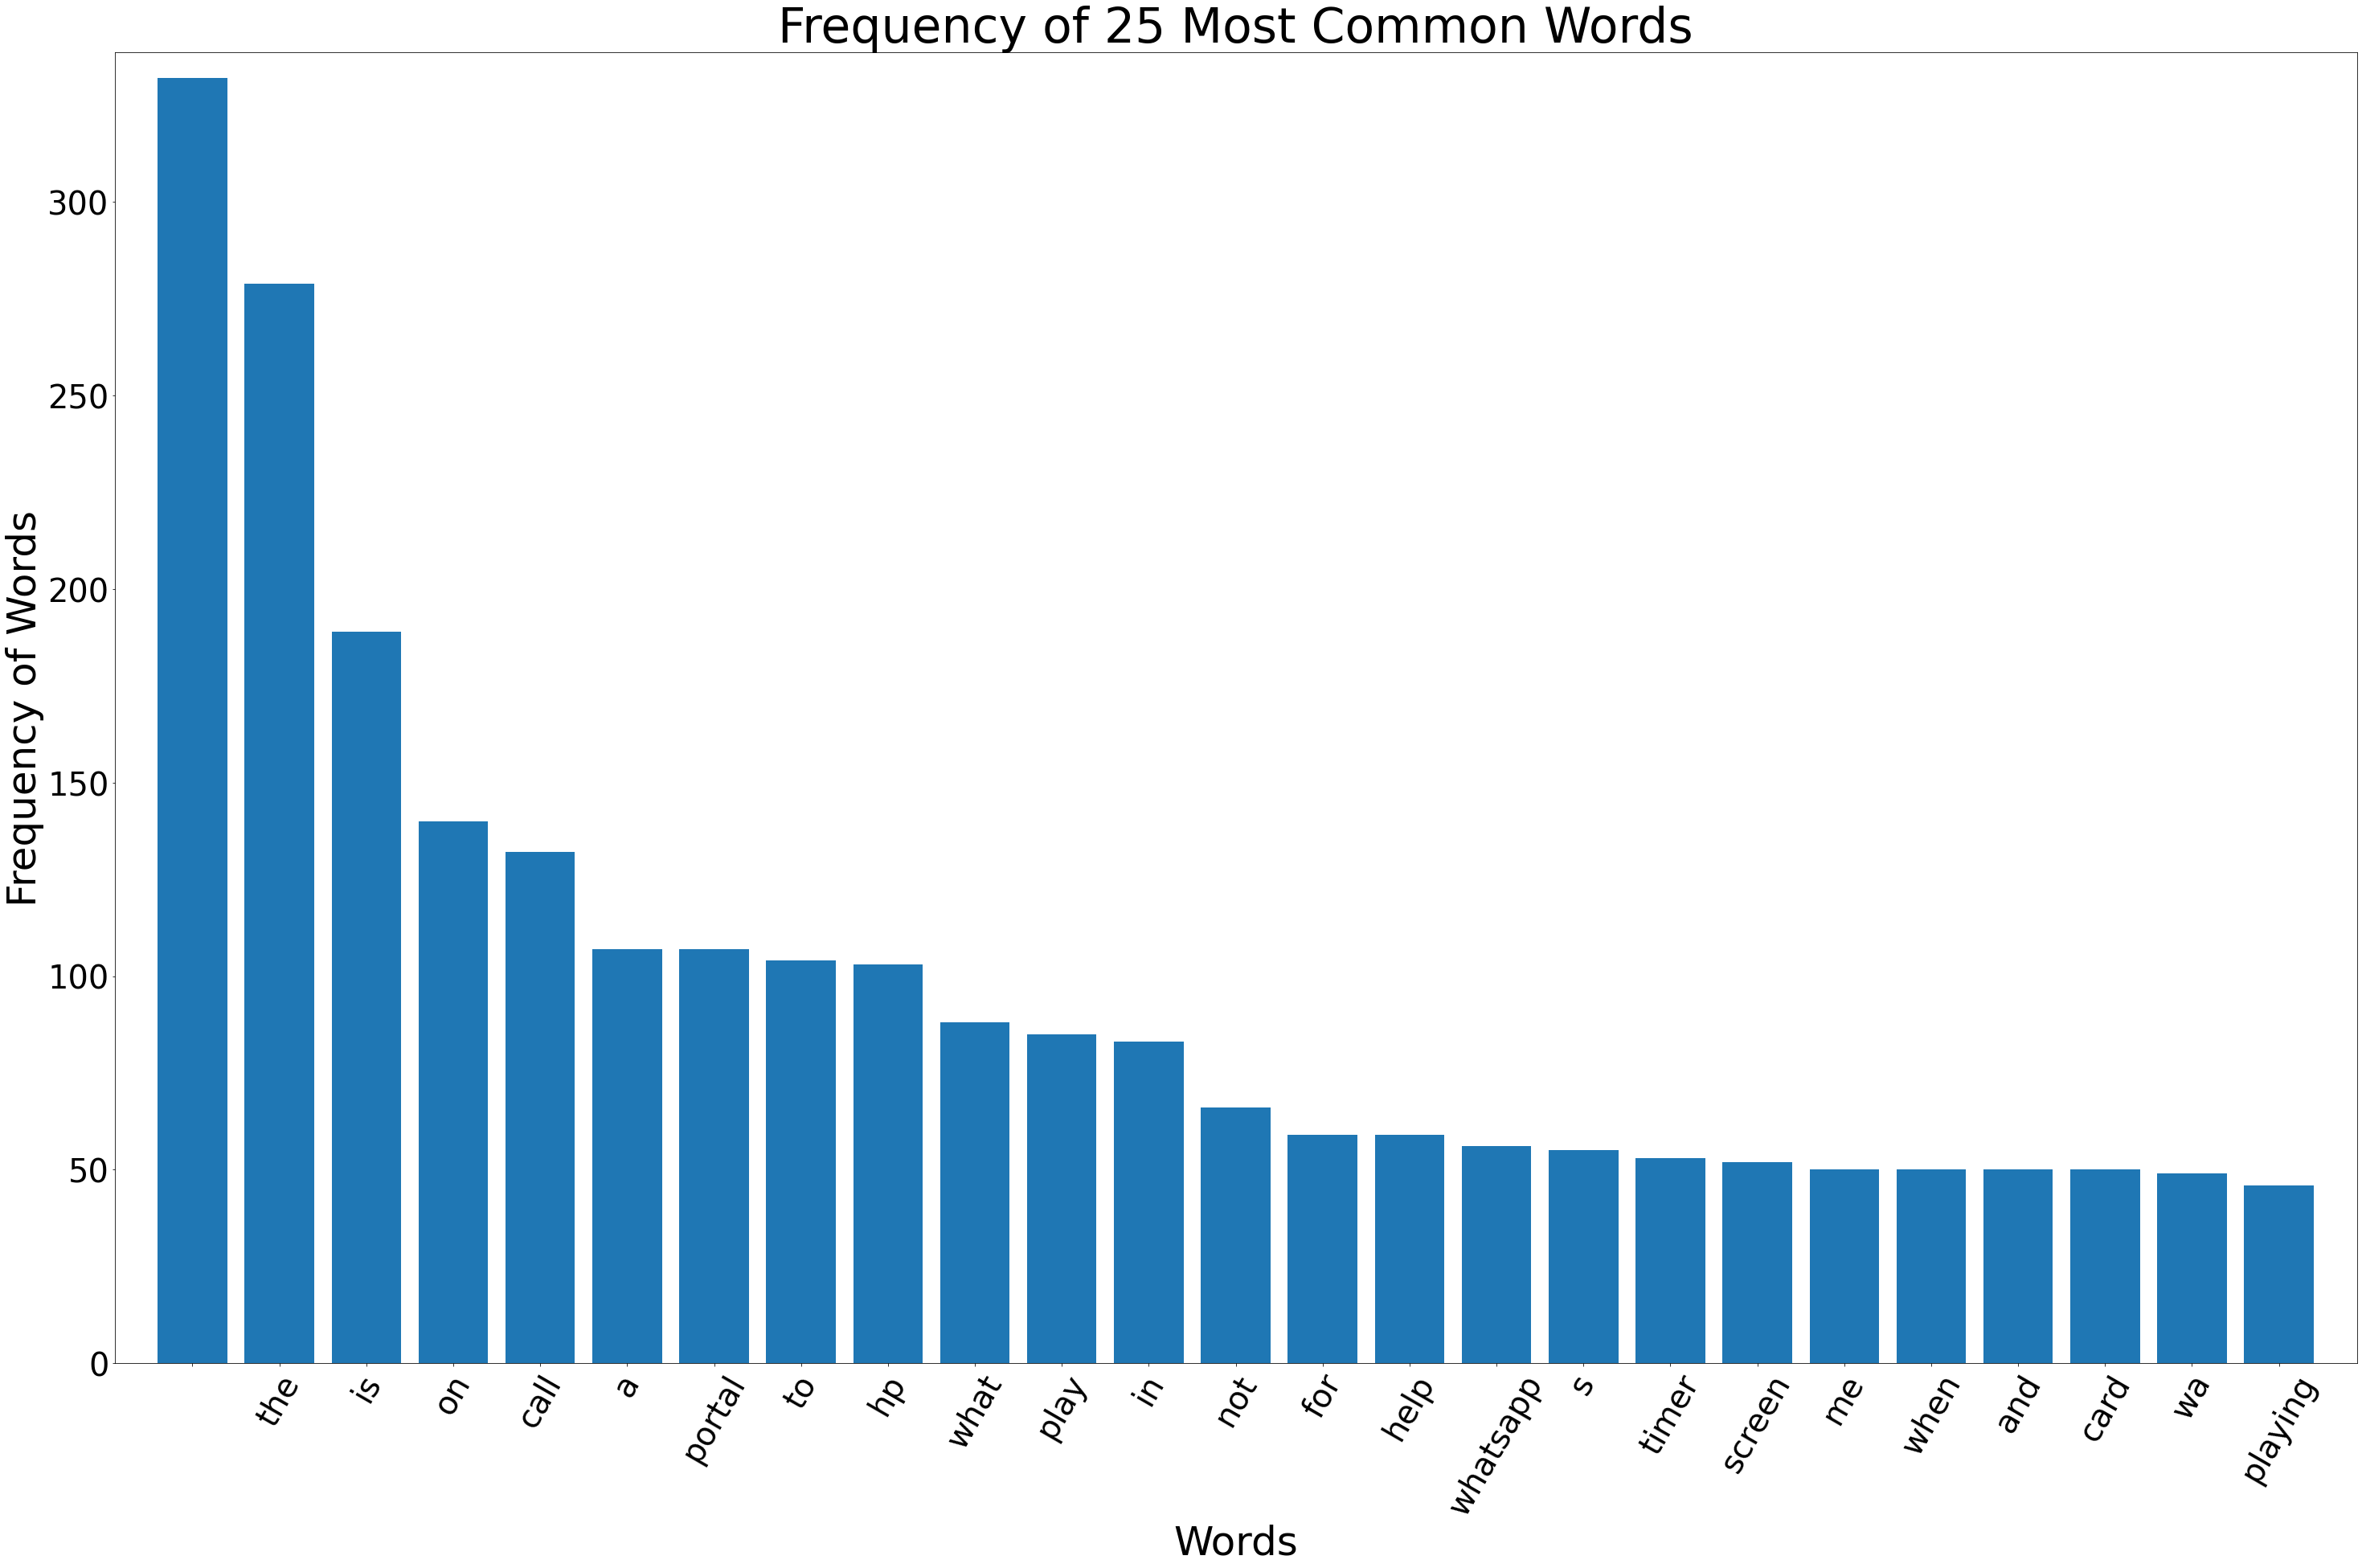

In [15]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

In [16]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(data['cleaned_text'], 20)
for word, freq in common_words:
    print(word, freq)
df5 = pd.DataFrame(common_words, columns = ['cleaned_text' , 'count'])
# df5.groupby('cleaned_text').sum()['count'].sort_values(ascending=False).iplot(
#     kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review before removing stop words')

# x_rating = pd.DataFrame(df5.groupby('cleaned_text').sum()['count'].sort_values(ascending=False))
# y_rating = x_rating.sort_index()
x_rating = data.Label.value_counts()
plt.figure(figsize=(50,30))
sns.barplot(df5.cleaned_text, df5.count, data=df5.astype({'count':'str'}))
plt.title("Label Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Labels', fontsize=50)
plt.xticks(fontsize=30,rotation=45)


portal is on 39
is on portal 39
on portal is 39
portal is not 39
is not muted 39
steps hp call 23
play the podcast 17
first time playing 16
time playing play 16
touch help card 16
touch back away 16
back away from 16
away from the 16
from the help 16
the help card 16
what is the 15
expected results pandora 15
not muted turn 12
pre conditions fb 12
conditions fb messenger 12


TypeError: unhashable type: 'DataFrame'

<Figure size 3600x2160 with 0 Axes>

In [21]:
df5

,cleaned_text,count
0,what is the,15
1,is it in,8
2,what the weather,6
3,what time is,6
4,set timer for,6
5,what will the,5
6,time is it,5
7,set brightness to,5
8,the weather like,4
9,is the forecast,4


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, 'Music'),
  Text(1, 0, 'Device'),
  Text(2, 0, 'Whatsapp_Calling'),
  Text(3, 0, 'Help_Touch_screen'),
  Text(4, 0, 'Timer'),
  Text(5, 0, 'Calling'),
  Text(6, 0, 'Music_QA'),
  Text(7, 0, 'Screen_Reader'),
  Text(8, 0, 'Weather'),
  Text(9, 0, 'Birthday'),
  Text(10, 0, 'AR_effect'),
  Text(11, 0, 'Alarm'),
  Text(12, 0, 'Whatsapp_Device'),
  Text(13, 0, 'Podcast'),
  Text(14, 0, 'Time'),
  Text(15, 0, 'Corona'),
  Text(16, 0, 'Meta'),
  Text(17, 0, 'Integrity'),
  Text(18, 0, 'News'),
  Text(19, 0, 'Wolfarm_food'),
  Text(20, 0, 'Assistant_messenger'),
  Text(21, 0, 'Photo'),
  Text(22, 0, 'Help')])

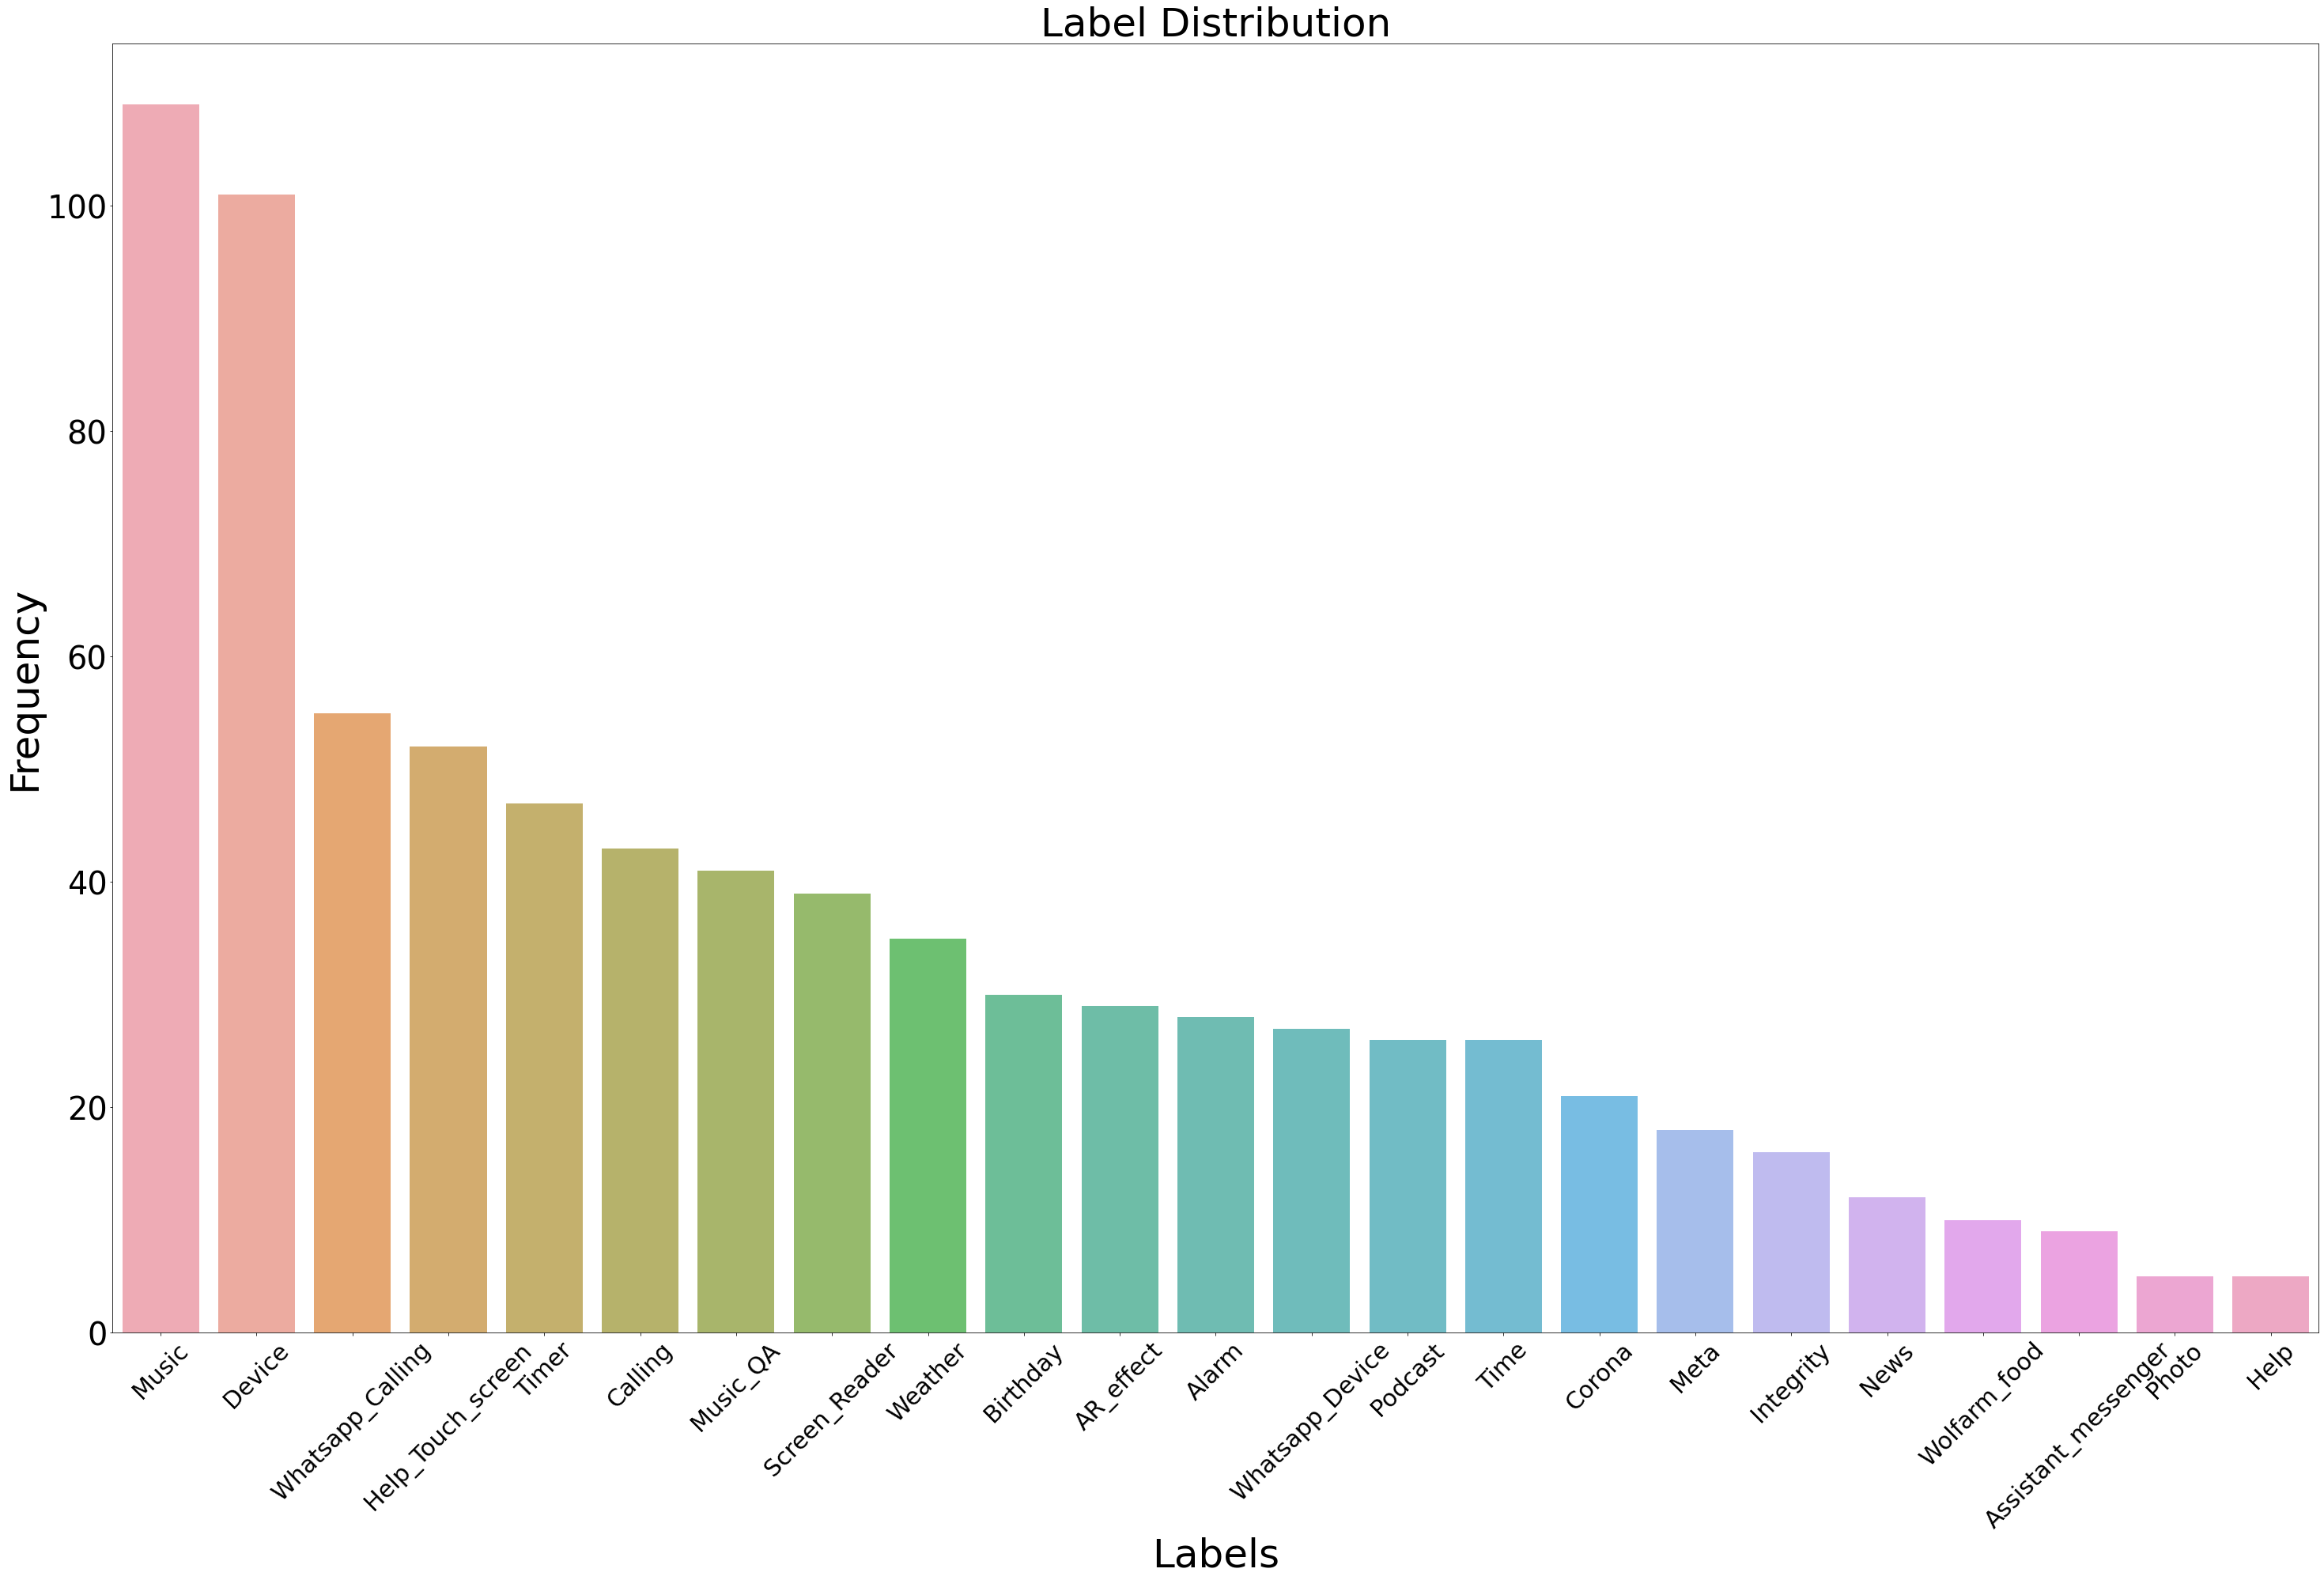

In [17]:
x_rating = data.Label.value_counts()
y_rating = x_rating.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x_rating.index, x_rating.values, alpha=0.8)
plt.title("Label Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Labels', fontsize=50)
plt.xticks(fontsize=30,rotation=45)

In [18]:
x_rating

Music                  109
Device                 101
Whatsapp_Calling        55
Help_Touch_screen       52
Timer                   47
Calling                 43
Music_QA                41
Screen_Reader           39
Weather                 35
Birthday                30
AR_effect               29
Alarm                   28
Whatsapp_Device         27
Podcast                 26
Time                    26
Corona                  21
Meta                    18
Integrity               16
News                    12
Wolfarm_food            10
Assistant_messenger      9
Photo                    5
Help                     5
Name: Label, dtype: int64

### Applying TF-IDF for getting common and rare words

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(min_df=.0025, max_df=.1, stop_words='english', ngram_range=(1, 1))
tvec_weights = tvec.fit_transform(list(data['cleaned_text']))
weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
299,portal,0.039728
291,play,0.032518
387,timer,0.029706
177,help,0.027052
386,time,0.026442
64,born,0.025675
333,screen,0.024798
67,brightness,0.023062
342,set,0.022082
397,turn,0.022074


In [20]:
weights_df

,term,weight
0,10,0.007099
1,100,0.001968
2,11,0.001210
3,12,0.001011
4,13,0.001032
...,...,...
423,wifi,0.001480
424,won,0.002066
425,work,0.002462
426,workout,0.002369


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'portal'),
  Text(1, 0, 'play'),
  Text(2, 0, 'timer'),
  Text(3, 0, 'help'),
  Text(4, 0, 'time'),
  Text(5, 0, 'born'),
  Text(6, 0, 'screen'),
  Text(7, 0, 'brightness'),
  Text(8, 0, 'set'),
  Text(9, 0, 'turn'),
  Text(10, 0, 'card'),
  Text(11, 0, 'open'),
  Text(12, 0, 'song'),
  Text(13, 0, 'alarm'),
  Text(14, 0, 'muted'),
  Text(15, 0, 'playing'),
  Text(16, 0, 'music'),
  Text(17, 0, 'touch'),
  Text(18, 0, 'whatsapp'),
  Text(19, 0, 'birthday')])

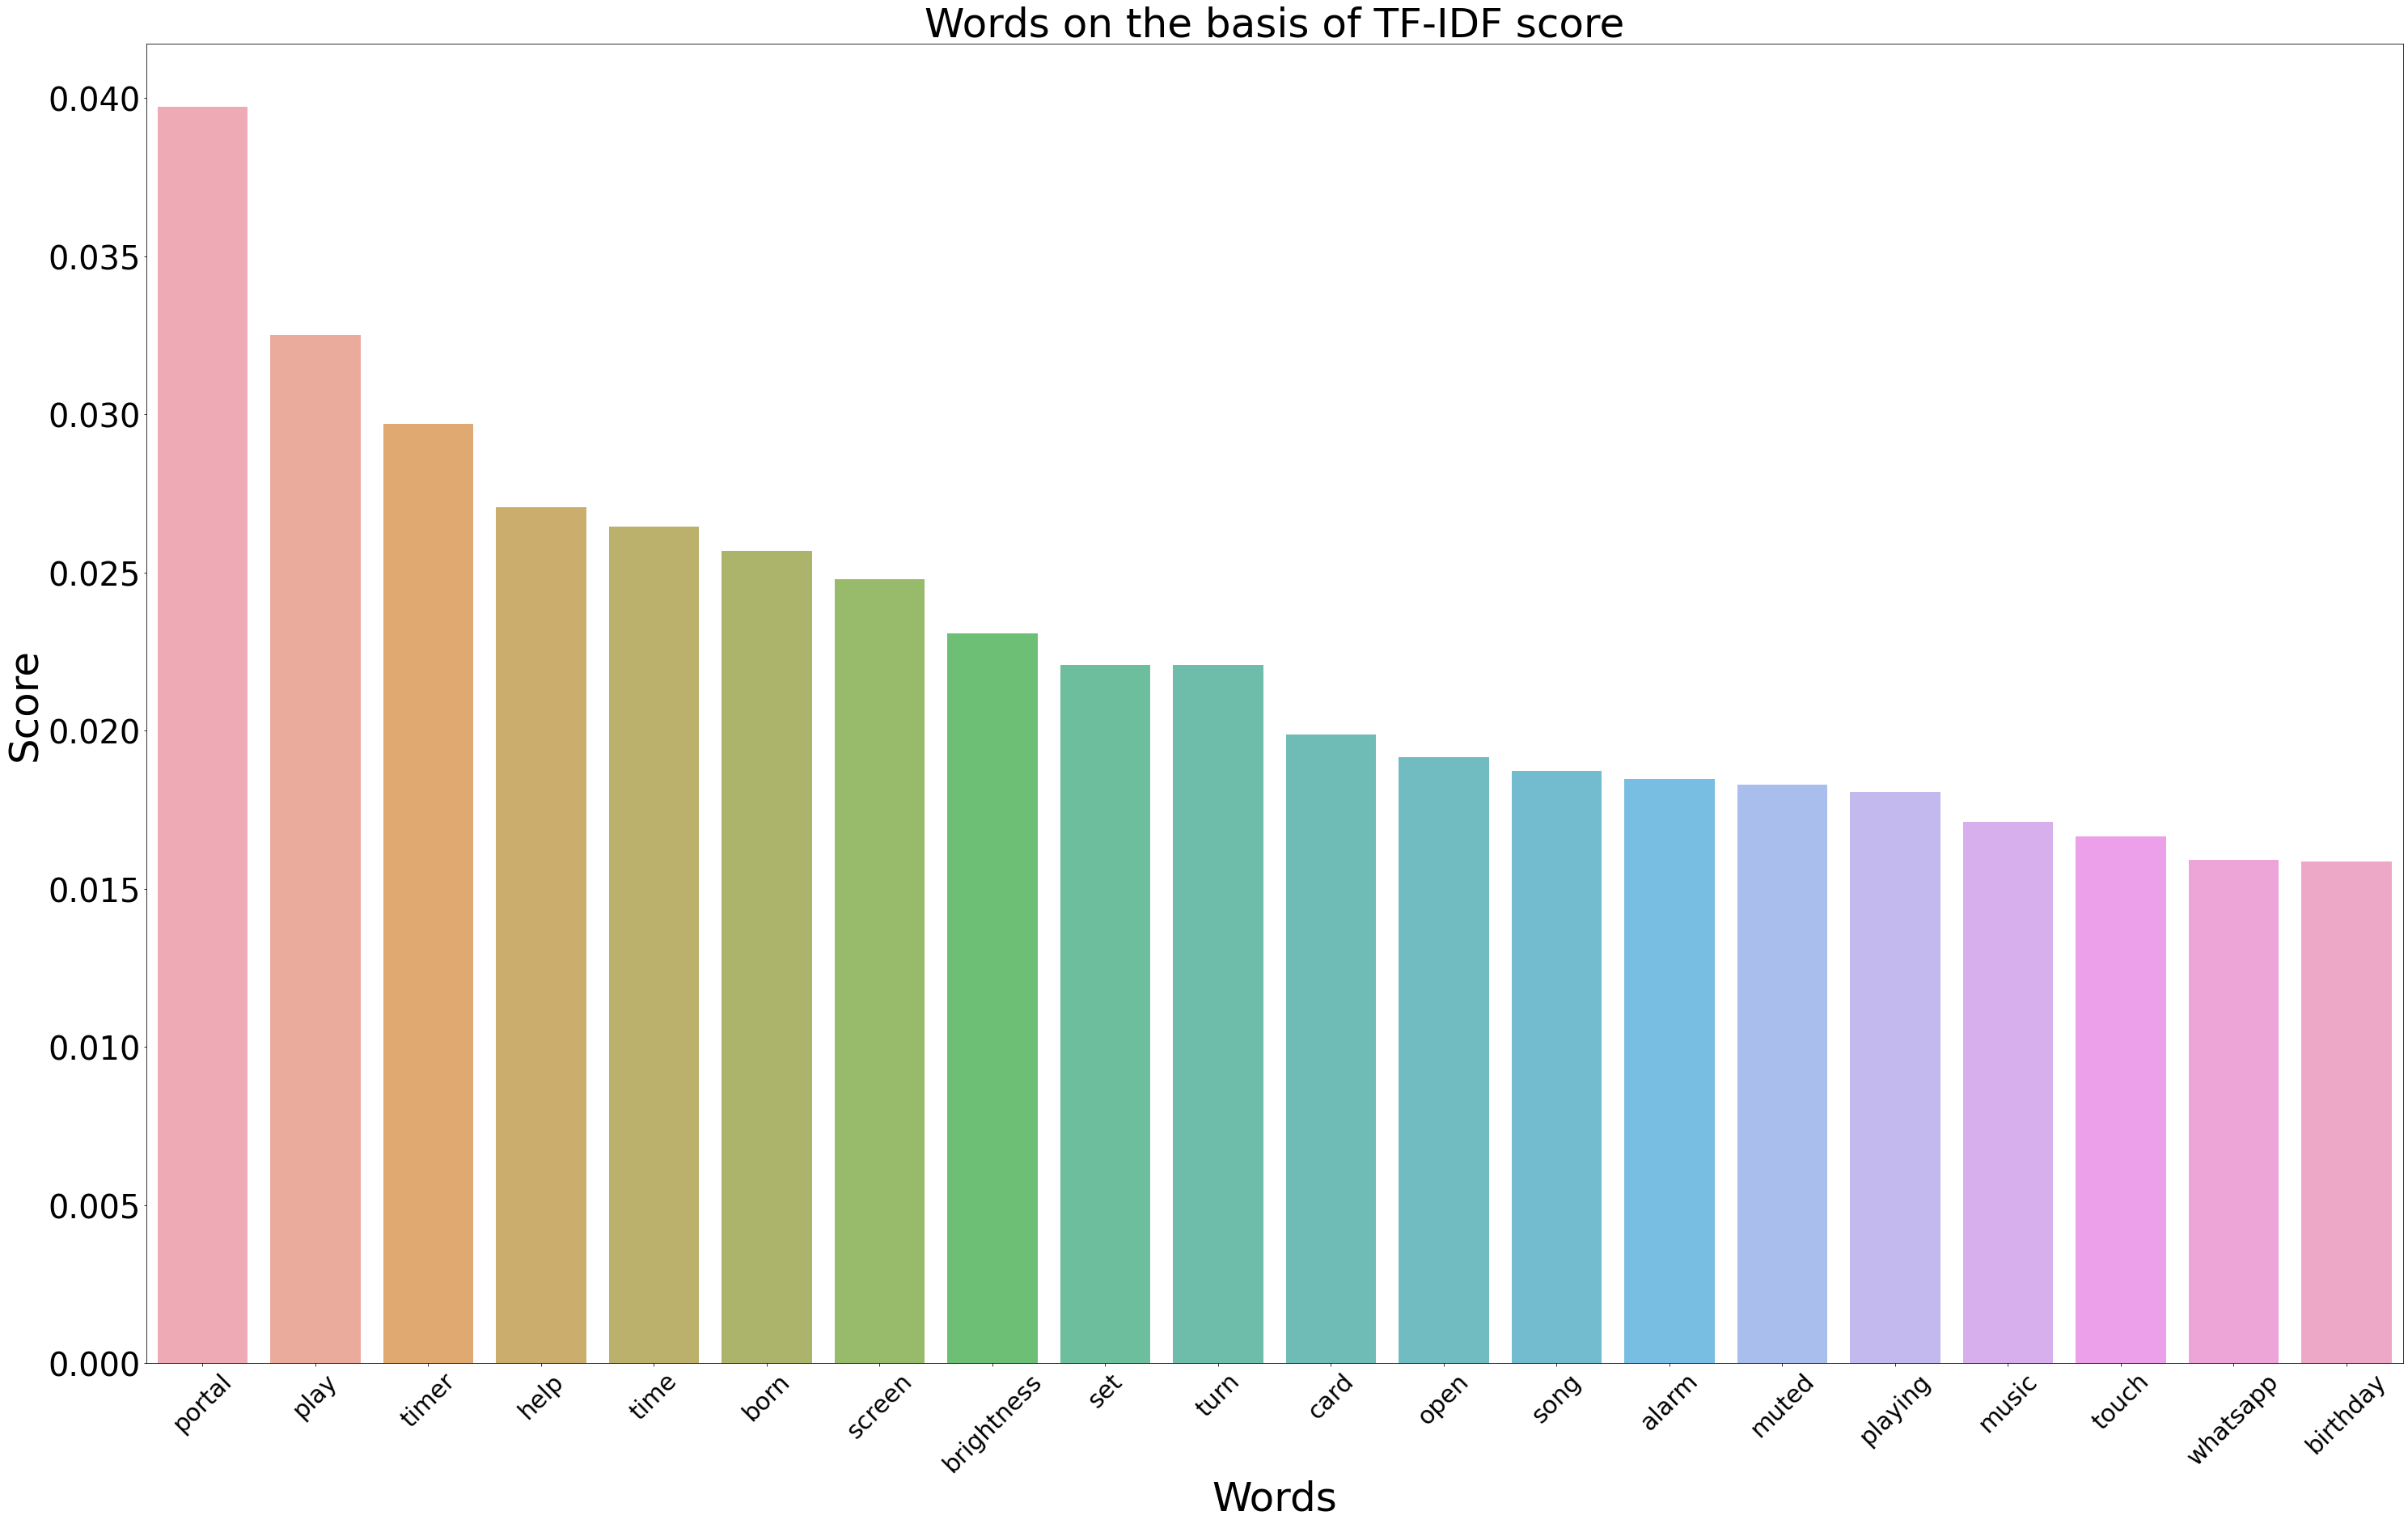

In [21]:
weights_df_top=weights_df.sort_values(by='weight', ascending=False).head(20)
y_rating = x_rating.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(weights_df_top.term, weights_df_top.weight, alpha=0.8)
plt.title("Words on the basis of TF-IDF score", fontsize=50)
plt.ylabel('Score', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Words', fontsize=50)
plt.xticks(fontsize=30,rotation=45)

#### Embedding the text

In [27]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

In [28]:
processed_doc = list(data['cleaned_text'])

In [29]:
tagged_doc=[TaggedDocument(words=word_tokenize(_d),tags=[str(i)]) for i, _d in enumerate(processed_doc)]

In [30]:
max_epochs = 10
vec_size = 30
alpha = 0.025

model = Doc2Vec(vector_size=vec_size, \
                alpha=alpha, \
                min_alpha=0.00025, \
                min_count=1, \
                dm =1)
  
model.build_vocab(tagged_doc)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_doc,
                total_examples=model.corpus_count, \
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


In [31]:
doc2vec_repr=[word_tokenize(doc) for doc in processed_doc]
doc2vec_vec=[model.infer_vector(doc) for doc in doc2vec_repr]

In [32]:
processed_doc[0]

'what s the weather like in chicago '

In [33]:
doc2vec_vec[0]

array([-0.00310895,  0.00542365, -0.06873067, -0.01869285, -0.008741  ,
        0.01799247,  0.04172995, -0.02252341, -0.00608837, -0.08783396,
       -0.04697356,  0.02027494,  0.00805444, -0.00860681, -0.01042133,
        0.04117309,  0.07210194,  0.0210564 , -0.03532428,  0.01795931,
        0.00949219,  0.05248747, -0.02997866,  0.04061206, -0.03522265,
        0.06409043, -0.04364884, -0.00284424,  0.03663217, -0.06678059],
      dtype=float32)

In [34]:
len(processed_doc)

321

In [35]:
data.shape

(321, 3)

In [36]:
len(doc2vec_vec)

321

### Sentence Embedding for Clustering the text by spaCy Transformer

In [17]:
import spacy
#import spacy_transformers
#from spacy.cli import download
#from tensorflow.python.keras import backend

nlp = spacy.load("en_core_web_trf")

In [18]:
data.head()

,Test Case Description,Label,cleaned_text
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today
3,Is it raining in France right now?,Weather,is it raining in france right now
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week


In [19]:
## Example of spaCy Transformer
for doc in nlp.pipe(["some text"]):
    tokvecs = doc._.trf_data.tensors[-1]
print(len(tokvecs))
tokvecs.shape
print(doc._.trf_data.tensors[0].shape)

1
(1, 4, 768)


- tensors ::: The activations for the Doc from the transformer. Usually the last tensor that is 3-dimensional will be the most important, as that will provide the final hidden state. Generally activations that are 2-dimensional will be attention weights. Details of this variable will differ depending on the underlying transformer model.

In [20]:
# for doc in nlp.pipe(list(data['cleaned_text'])):
#     vectors = doc._.trf_data.tensors[-1]

def get_embeddings(text):
    return nlp(text)._.trf_data.tensors[-1][0]

data['embeddings_spaCy'] = data['cleaned_text'].apply(get_embeddings)

In [21]:
data['Label'].value_counts()

Device                 133
Music                  111
Calling                 89
Music_QA                71
Help                    51
Timer                   47
Screen_Reader           39
Weather                 35
Alarm                   30
AR_effect               29
Time                    26
Corona                  21
Integrity               16
Meta                    12
News                    12
Wolfarm_food            10
Assistant_messenger      8
Name: Label, dtype: int64

In [22]:
data.head()

,Test Case Description,Label,cleaned_text,embeddings_spaCy
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago,"[0.39099964, 0.22187115, 0.05214785, 0.28463787, 0.13723904, -0.17857912, 0.70306545, -0.041043606, -0.17102624, -0.4185157, 0.09127296, -0.011548319, 0.17552137, 0.4750681, -0.3593003, 0.16939116..."
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow,"[0.37388843, 0.4594913, 0.06047645, 0.1588928, 1.18762255e-05, -0.24013336, 0.5891916, -0.2188668, -0.23997031, -0.56834376, -0.050958026, -0.035789233, 0.23429373, 0.4918924, -0.34998745, -0.0326..."
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today,"[0.38037655, 0.49527752, 0.056031726, 0.17981578, 0.073269114, -0.20634057, 0.55292815, -0.26100457, -0.20759988, -0.5136793, -0.04676803, -0.038770217, 0.22752112, 0.4475448, -0.4051883, 0.076300..."
3,Is it raining in France right now?,Weather,is it raining in france right now,"[0.3607063, 0.3206141, -0.06231572, 0.49461597, -0.19429666, -0.3310444, 0.6432384, 0.16533442, -0.2383273, -0.6529438, 0.1455032, 0.089554206, 0.20580941, 0.516538, -0.5564028, 0.18595973, -0.026..."
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week,"[0.44744533, 0.45410064, 0.10522262, 0.24095279, -0.00090906746, -0.21411118, 0.6833708, -0.18369187, -0.28700188, -0.5887493, 0.11417359, 0.17329024, 0.14500135, 0.5309677, -0.33833912, 0.1548844..."


#### Clustering using nltk KMeansClusterer

In [33]:
## Import libraries
from nltk.cluster import KMeansClusterer
import nltk
from sklearn.manifold import TSNE

def clustering_data(data,NUM_CLUSTERS = 17):

    sentences = data['cleaned_text']

    X = np.array(data['embeddings_spaCy'].tolist())

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=10,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    data['cluster'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid'] = data['cluster'].apply(lambda x: kclusterer.means()[x])
    
    

#         #Getting unique labels

#     u_labels = np.unique( data['cluster'])
#     label = data['cluster']
#     #plotting the results:

#     for i in u_labels:
#         plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
#     plt.legend()
#     plt.show()

    return data, assigned_clusters

In [34]:
data,cluster=clustering_data(data)

In [35]:
data.head()

,Test Case Description,Label,cleaned_text,embeddings_spaCy,cluster,centroid,distance_from_centroid,k_means_spaCy
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago,"[0.39099964, 0.22187115, 0.05214785, 0.28463787, 0.13723904, -0.17857912, 0.70306545, -0.041043606, -0.17102624, -0.4185157, 0.09127296, -0.011548319, 0.17552137, 0.4750681, -0.3593003, 0.16939116...",10,"[0.43549743, 0.42281199, 0.11073053, 0.2677779, 0.004500212, -0.2510872, 0.5933197, -0.20490706, -0.27242213, -0.5723256, 0.056027394, -0.025331806, 0.1621705, 0.47100073, -0.3212627, 0.09180617, ...",2.654577,4
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow,"[0.37388843, 0.4594913, 0.06047645, 0.1588928, 1.18762255e-05, -0.24013336, 0.5891916, -0.2188668, -0.23997031, -0.56834376, -0.050958026, -0.035789233, 0.23429373, 0.4918924, -0.34998745, -0.0326...",10,"[0.43549743, 0.42281199, 0.11073053, 0.2677779, 0.004500212, -0.2510872, 0.5933197, -0.20490706, -0.27242213, -0.5723256, 0.056027394, -0.025331806, 0.1621705, 0.47100073, -0.3212627, 0.09180617, ...",1.951492,4
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today,"[0.38037655, 0.49527752, 0.056031726, 0.17981578, 0.073269114, -0.20634057, 0.55292815, -0.26100457, -0.20759988, -0.5136793, -0.04676803, -0.038770217, 0.22752112, 0.4475448, -0.4051883, 0.076300...",10,"[0.43549743, 0.42281199, 0.11073053, 0.2677779, 0.004500212, -0.2510872, 0.5933197, -0.20490706, -0.27242213, -0.5723256, 0.056027394, -0.025331806, 0.1621705, 0.47100073, -0.3212627, 0.09180617, ...",1.956759,4
3,Is it raining in France right now?,Weather,is it raining in france right now,"[0.3607063, 0.3206141, -0.06231572, 0.49461597, -0.19429666, -0.3310444, 0.6432384, 0.16533442, -0.2383273, -0.6529438, 0.1455032, 0.089554206, 0.20580941, 0.516538, -0.5564028, 0.18595973, -0.026...",6,"[0.42366695, 0.27313936, -0.1471229, 0.2969683, -0.13046558, -0.13526769, 0.6289037, 0.046941914, -0.31098527, -0.59129417, 0.296394, -0.10164251, 0.2370117, 0.6026351, -0.4967972, 0.28011677, -0....",2.915422,2
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week,"[0.44744533, 0.45410064, 0.10522262, 0.24095279, -0.00090906746, -0.21411118, 0.6833708, -0.18369187, -0.28700188, -0.5887493, 0.11417359, 0.17329024, 0.14500135, 0.5309677, -0.33833912, 0.1548844...",11,"[0.4446704, 0.40524355, 0.16422297, 0.26095822, -0.07036028, -0.21692269, 0.67949563, -0.2044974, -0.3316126, -0.63184017, 0.25494412, 0.028538635, 0.14761718, 0.5282492, -0.3328145, 0.16856036, -...",2.098996,1


### Visualization using TSNE

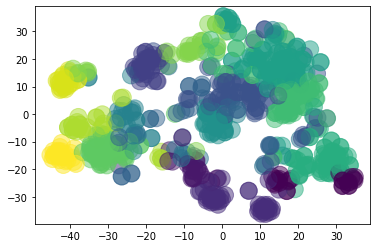

In [36]:
X = np.array(data['embeddings_spaCy'].tolist())

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y=model.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=cluster, s=290,alpha=.5)
plt.show()

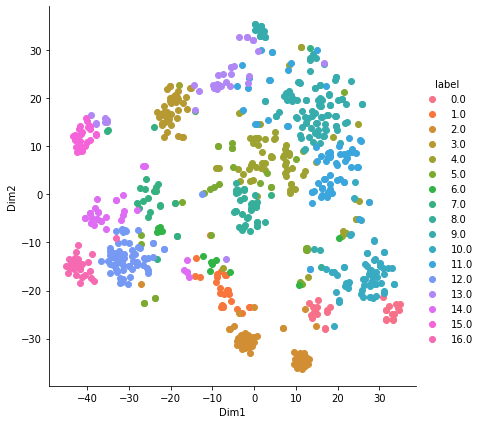

In [37]:
import numpy as np
import seaborn as sns
tnse_data=np.vstack((Y.T, cluster)).T
tsne_df=pd.DataFrame(data=tnse_data, columns=('Dim1','Dim2','label'))

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

#### Claculating distance of the point from it's cluster centroid

In [28]:
from scipy.spatial import distance_matrix
def distance_from_centroid(row):
    # type of emb and centroid is different, hence using tolist below
    return distance_matrix([row['embeddings_spaCy']], [row['centroid'].tolist()])[0][0]

# Compute centroid distance to the data
data['distance_from_centroid'] = data.apply(distance_from_centroid, axis=1)

In [29]:
data.head()

,Test Case Description,Label,cleaned_text,embeddings_spaCy,cluster,centroid,distance_from_centroid
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago,"[0.39099964, 0.22187115, 0.05214785, 0.28463787, 0.13723904, -0.17857912, 0.70306545, -0.041043606, -0.17102624, -0.4185157, 0.09127296, -0.011548319, 0.17552137, 0.4750681, -0.3593003, 0.16939116...",3,"[0.4571555, 0.3951165, 0.07677533, 0.29821333, -0.035089493, -0.23782203, 0.5969457, -0.19572075, -0.29519394, -0.609929, 0.066918425, -0.04121979, 0.1755916, 0.47330126, -0.32118675, 0.11192532, ...",2.654577
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow,"[0.37388843, 0.4594913, 0.06047645, 0.1588928, 1.18762255e-05, -0.24013336, 0.5891916, -0.2188668, -0.23997031, -0.56834376, -0.050958026, -0.035789233, 0.23429373, 0.4918924, -0.34998745, -0.0326...",3,"[0.4571555, 0.3951165, 0.07677533, 0.29821333, -0.035089493, -0.23782203, 0.5969457, -0.19572075, -0.29519394, -0.609929, 0.066918425, -0.04121979, 0.1755916, 0.47330126, -0.32118675, 0.11192532, ...",1.951492
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today,"[0.38037655, 0.49527752, 0.056031726, 0.17981578, 0.073269114, -0.20634057, 0.55292815, -0.26100457, -0.20759988, -0.5136793, -0.04676803, -0.038770217, 0.22752112, 0.4475448, -0.4051883, 0.076300...",3,"[0.4571555, 0.3951165, 0.07677533, 0.29821333, -0.035089493, -0.23782203, 0.5969457, -0.19572075, -0.29519394, -0.609929, 0.066918425, -0.04121979, 0.1755916, 0.47330126, -0.32118675, 0.11192532, ...",1.956759
3,Is it raining in France right now?,Weather,is it raining in france right now,"[0.3607063, 0.3206141, -0.06231572, 0.49461597, -0.19429666, -0.3310444, 0.6432384, 0.16533442, -0.2383273, -0.6529438, 0.1455032, 0.089554206, 0.20580941, 0.516538, -0.5564028, 0.18595973, -0.026...",2,"[0.4709879, 0.30460244, 0.006968078, 0.3215507, -0.13421828, -0.15841113, 0.6564091, -0.098549545, -0.3293593, -0.5990897, 0.2971204, 0.00015132662, 0.16437046, 0.5286389, -0.34194753, 0.24707714,...",2.915422
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week,"[0.44744533, 0.45410064, 0.10522262, 0.24095279, -0.00090906746, -0.21411118, 0.6833708, -0.18369187, -0.28700188, -0.5887493, 0.11417359, 0.17329024, 0.14500135, 0.5309677, -0.33833912, 0.1548844...",4,"[0.4505203, 0.39399514, 0.1312584, 0.28009862, -0.08617284, -0.2288327, 0.6580521, -0.17718431, -0.29289925, -0.632958, 0.25507748, 0.021711793, 0.16876532, 0.50446767, -0.30704406, 0.118803054, -...",2.098996


In [30]:
# vectors=data['embeddings']
# clusters=cluster
# centroids=data['centroid']
# x0 = np.array([x[0] for idx, x in enumerate(vectors) if clusters[idx]==0])
# y0 = np.array([x[1] for idx, x in enumerate(vectors) if clusters[idx]==0])
# plt.scatter(x0,y0, color='blue')
# x1 = np.array([x[0] for idx, x in enumerate(vectors) if clusters[idx]==1])
# y1 = np.array([x[1] for idx, x in enumerate(vectors) if clusters[idx]==1])
# plt.scatter(x1,y1, color='red')
# x0 = np.array([x[0] for idx, x in enumerate(vectors) if clusters[idx]==2])
# y0 = np.array([x[1] for idx, x in enumerate(vectors) if clusters[idx]==2])
# plt.scatter(x0,y0, color='green')
# x1 = np.array([x[0] for idx, x in enumerate(vectors) if clusters[idx]==3])
# y1 = np.array([x[1] for idx, x in enumerate(vectors) if clusters[idx]==3])
# plt.scatter(x1,y1, color='yellow')

# # xc = np.array([x[0] for x in centroids])
# # yc = np.array([x[1] for x in centroids])
# # plt.scatter(xc,yc, color='orange')
# plt.show()

In [38]:
from sklearn.cluster import KMeans

In [39]:
# Perform kmean clustering
num_clusters = 17
clustering_model = KMeans(n_clusters=num_clusters,max_iter=20)
clustering_model.fit(list(data['embeddings_spaCy']))
cluster_assignment = clustering_model.labels_
data['k_means_spaCy']=cluster_assignment

In [40]:
data.head()

,Test Case Description,Label,cleaned_text,embeddings_spaCy,cluster,centroid,distance_from_centroid,k_means_spaCy
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago,"[0.39099964, 0.22187115, 0.05214785, 0.28463787, 0.13723904, -0.17857912, 0.70306545, -0.041043606, -0.17102624, -0.4185157, 0.09127296, -0.011548319, 0.17552137, 0.4750681, -0.3593003, 0.16939116...",10,"[0.43549743, 0.42281199, 0.11073053, 0.2677779, 0.004500212, -0.2510872, 0.5933197, -0.20490706, -0.27242213, -0.5723256, 0.056027394, -0.025331806, 0.1621705, 0.47100073, -0.3212627, 0.09180617, ...",2.654577,0
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow,"[0.37388843, 0.4594913, 0.06047645, 0.1588928, 1.18762255e-05, -0.24013336, 0.5891916, -0.2188668, -0.23997031, -0.56834376, -0.050958026, -0.035789233, 0.23429373, 0.4918924, -0.34998745, -0.0326...",10,"[0.43549743, 0.42281199, 0.11073053, 0.2677779, 0.004500212, -0.2510872, 0.5933197, -0.20490706, -0.27242213, -0.5723256, 0.056027394, -0.025331806, 0.1621705, 0.47100073, -0.3212627, 0.09180617, ...",1.951492,0
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today,"[0.38037655, 0.49527752, 0.056031726, 0.17981578, 0.073269114, -0.20634057, 0.55292815, -0.26100457, -0.20759988, -0.5136793, -0.04676803, -0.038770217, 0.22752112, 0.4475448, -0.4051883, 0.076300...",10,"[0.43549743, 0.42281199, 0.11073053, 0.2677779, 0.004500212, -0.2510872, 0.5933197, -0.20490706, -0.27242213, -0.5723256, 0.056027394, -0.025331806, 0.1621705, 0.47100073, -0.3212627, 0.09180617, ...",1.956759,0
3,Is it raining in France right now?,Weather,is it raining in france right now,"[0.3607063, 0.3206141, -0.06231572, 0.49461597, -0.19429666, -0.3310444, 0.6432384, 0.16533442, -0.2383273, -0.6529438, 0.1455032, 0.089554206, 0.20580941, 0.516538, -0.5564028, 0.18595973, -0.026...",6,"[0.42366695, 0.27313936, -0.1471229, 0.2969683, -0.13046558, -0.13526769, 0.6289037, 0.046941914, -0.31098527, -0.59129417, 0.296394, -0.10164251, 0.2370117, 0.6026351, -0.4967972, 0.28011677, -0....",2.915422,10
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week,"[0.44744533, 0.45410064, 0.10522262, 0.24095279, -0.00090906746, -0.21411118, 0.6833708, -0.18369187, -0.28700188, -0.5887493, 0.11417359, 0.17329024, 0.14500135, 0.5309677, -0.33833912, 0.1548844...",11,"[0.4446704, 0.40524355, 0.16422297, 0.26095822, -0.07036028, -0.21692269, 0.67949563, -0.2044974, -0.3316126, -0.63184017, 0.25494412, 0.028538635, 0.14761718, 0.5282492, -0.3328145, 0.16856036, -...",2.098996,4


In [41]:
data['cluster'].value_counts()

9     107
4      72
11     71
10     64
12     61
2      50
3      39
8      35
13     35
14     32
5      31
0      28
16     27
1      25
15     25
7      24
6      14
Name: cluster, dtype: int64

## Sentence Embedding and applying clustering on it by using sentence_transformers

#### Trying with all-MiniLM-L6-v2 pre-trained model

In [42]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

In [43]:
#  sentences we like to encode
# sentences = ['This framework generates embeddings for each input sentence',
#     'Sentences are passed as a list of string.', 
#     'The quick brown fox jumps over the lazy dog.']

# #Sentences are encoded by calling model.encode()
# sentence_embeddings = model.encode(sentences)

# #Print the embeddings
# for sentence, embedding in zip(sentences, sentence_embeddings):
#     print("Sentence:", sentence)
#     print("Embedding:", embedding)
#     print('========================',len(embedding))
#     print('========================',embedding.shape)
#     print("")
    


In [44]:
def embeddings(data):
    sentence_embeddings = model.encode(list(data['cleaned_text']))
    return sentence_embeddings
embeddings_trs=embeddings(data)

In [45]:
data['embediing_trf']=list(embeddings_trs)

In [46]:
data.head()

,Test Case Description,Label,cleaned_text,embeddings_spaCy,cluster,centroid,distance_from_centroid,k_means_spaCy,embediing_trf
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago,"[0.39099964, 0.22187115, 0.05214785, 0.28463787, 0.13723904, -0.17857912, 0.70306545, -0.041043606, -0.17102624, -0.4185157, 0.09127296, -0.011548319, 0.17552137, 0.4750681, -0.3593003, 0.16939116...",10,"[0.43549743, 0.42281199, 0.11073053, 0.2677779, 0.004500212, -0.2510872, 0.5933197, -0.20490706, -0.27242213, -0.5723256, 0.056027394, -0.025331806, 0.1621705, 0.47100073, -0.3212627, 0.09180617, ...",2.654577,0,"[0.007616806, 0.005843046, 0.11240678, 0.050339803, 0.0025280218, 0.05087099, -0.008886891, -0.036157727, -0.08662188, 0.0311569, 0.01335425, -0.052121345, -0.08929149, -0.041871995, -0.033586346,..."
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow,"[0.37388843, 0.4594913, 0.06047645, 0.1588928, 1.18762255e-05, -0.24013336, 0.5891916, -0.2188668, -0.23997031, -0.56834376, -0.050958026, -0.035789233, 0.23429373, 0.4918924, -0.34998745, -0.0326...",10,"[0.43549743, 0.42281199, 0.11073053, 0.2677779, 0.004500212, -0.2510872, 0.5933197, -0.20490706, -0.27242213, -0.5723256, 0.056027394, -0.025331806, 0.1621705, 0.47100073, -0.3212627, 0.09180617, ...",1.951492,0,"[-0.061214603, -0.03637533, 0.017356902, 0.11064822, 0.034364026, 0.008444189, -0.029829586, 0.0496172, -0.008215639, -0.014838837, -0.055373635, 0.01605187, -0.072400905, 0.047417916, 0.013640420..."
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today,"[0.38037655, 0.49527752, 0.056031726, 0.17981578, 0.073269114, -0.20634057, 0.55292815, -0.26100457, -0.20759988, -0.5136793, -0.04676803, -0.038770217, 0.22752112, 0.4475448, -0.4051883, 0.076300...",10,"[0.43549743, 0.42281199, 0.11073053, 0.2677779, 0.004500212, -0.2510872, 0.5933197, -0.20490706, -0.27242213, -0.5723256, 0.056027394, -0.025331806, 0.1621705, 0.47100073, -0.3212627, 0.09180617, ...",1.956759,0,"[-0.0097305225, 0.053419128, 0.11421346, 0.08534336, -0.0020916641, -0.017286684, 0.0074873744, -0.06525992, -0.013874442, 0.0016921109, -0.036969505, -0.05427649, 0.01839362, -0.028270833, 0.0616..."
3,Is it raining in France right now?,Weather,is it raining in france right now,"[0.3607063, 0.3206141, -0.06231572, 0.49461597, -0.19429666, -0.3310444, 0.6432384, 0.16533442, -0.2383273, -0.6529438, 0.1455032, 0.089554206, 0.20580941, 0.516538, -0.5564028, 0.18595973, -0.026...",6,"[0.42366695, 0.27313936, -0.1471229, 0.2969683, -0.13046558, -0.13526769, 0.6289037, 0.046941914, -0.31098527, -0.59129417, 0.296394, -0.10164251, 0.2370117, 0.6026351, -0.4967972, 0.28011677, -0....",2.915422,10,"[0.010006898, -0.03475733, 0.08833386, -0.013573887, 0.11943102, -0.011142135, 0.029939154, -0.078966804, -0.011841778, 0.02961379, -0.06445307, -0.016232042, 0.0030896598, 0.061305318, -0.0309999..."
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week,"[0.44744533, 0.45410064, 0.10522262, 0.24095279, -0.00090906746, -0.21411118, 0.6833708, -0.18369187, -0.28700188, -0.5887493, 0.11417359, 0.17329024, 0.14500135, 0.5309677, -0.33833912, 0.1548844...",11,"[0.4446704, 0.40524355, 0.16422297, 0.26095822, -0.07036028, -0.21692269, 0.67949563, -0.2044974, -0.3316126, -0.63184017, 0.25494412, 0.028538635, 0.14761718, 0.5282492, -0.3328145, 0.16856036, -...",2.098996,4,"[-0.04503107, 0.050213095, 0.08135208, 0.08382549, 0.07056702, -0.014506211, -0.047058657, -0.0029406156, -0.09286148, -0.055706646, -0.048554093, -0.11892626, 0.049603157, 0.039010234, 0.01484314..."


##### Clustering by KMeansClusterer

In [55]:
def clustering_data_trf(data,NUM_CLUSTERS = 17):

    sentences = data['cleaned_text']

    X = np.array(data['embediing_trf'].tolist())

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=5,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    data['cluster_trf'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid_trf'] = data['cluster_trf'].apply(lambda x: kclusterer.means()[x])
    return data, assigned_clusters

In [48]:
data, cluster_trf=clustering_data_trf(data)

In [49]:
data.head()

,Test Case Description,Label,cleaned_text,embeddings_spaCy,cluster,centroid,distance_from_centroid,k_means_spaCy,embediing_trf,cluster_trf,centroid_trf
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago,"[0.39099964, 0.22187115, 0.05214785, 0.28463787, 0.13723904, -0.17857912, 0.70306545, -0.041043606, -0.17102624, -0.4185157, 0.09127296, -0.011548319, 0.17552137, 0.4750681, -0.3593003, 0.16939116...",10,"[0.43549743, 0.42281199, 0.11073053, 0.2677779, 0.004500212, -0.2510872, 0.5933197, -0.20490706, -0.27242213, -0.5723256, 0.056027394, -0.025331806, 0.1621705, 0.47100073, -0.3212627, 0.09180617, ...",2.654577,0,"[0.007616806, 0.005843046, 0.11240678, 0.050339803, 0.0025280218, 0.05087099, -0.008886891, -0.036157727, -0.08662188, 0.0311569, 0.01335425, -0.052121345, -0.08929149, -0.041871995, -0.033586346,...",1,"[-0.0063418048, 0.02619918, 0.028854096, 0.03329149, 0.009774283, 0.0004131784, 0.0013373792, -0.023708915, -0.014908327, 0.018002322, -0.027866563, -0.025774963, -0.026670309, 0.017449077, 0.0152..."
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow,"[0.37388843, 0.4594913, 0.06047645, 0.1588928, 1.18762255e-05, -0.24013336, 0.5891916, -0.2188668, -0.23997031, -0.56834376, -0.050958026, -0.035789233, 0.23429373, 0.4918924, -0.34998745, -0.0326...",10,"[0.43549743, 0.42281199, 0.11073053, 0.2677779, 0.004500212, -0.2510872, 0.5933197, -0.20490706, -0.27242213, -0.5723256, 0.056027394, -0.025331806, 0.1621705, 0.47100073, -0.3212627, 0.09180617, ...",1.951492,0,"[-0.061214603, -0.03637533, 0.017356902, 0.11064822, 0.034364026, 0.008444189, -0.029829586, 0.0496172, -0.008215639, -0.014838837, -0.055373635, 0.01605187, -0.072400905, 0.047417916, 0.013640420...",1,"[-0.0063418048, 0.02619918, 0.028854096, 0.03329149, 0.009774283, 0.0004131784, 0.0013373792, -0.023708915, -0.014908327, 0.018002322, -0.027866563, -0.025774963, -0.026670309, 0.017449077, 0.0152..."
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today,"[0.38037655, 0.49527752, 0.056031726, 0.17981578, 0.073269114, -0.20634057, 0.55292815, -0.26100457, -0.20759988, -0.5136793, -0.04676803, -0.038770217, 0.22752112, 0.4475448, -0.4051883, 0.076300...",10,"[0.43549743, 0.42281199, 0.11073053, 0.2677779, 0.004500212, -0.2510872, 0.5933197, -0.20490706, -0.27242213, -0.5723256, 0.056027394, -0.025331806, 0.1621705, 0.47100073, -0.3212627, 0.09180617, ...",1.956759,0,"[-0.0097305225, 0.053419128, 0.11421346, 0.08534336, -0.0020916641, -0.017286684, 0.0074873744, -0.06525992, -0.013874442, 0.0016921109, -0.036969505, -0.05427649, 0.01839362, -0.028270833, 0.0616...",1,"[-0.0063418048, 0.02619918, 0.028854096, 0.03329149, 0.009774283, 0.0004131784, 0.0013373792, -0.023708915, -0.014908327, 0.018002322, -0.027866563, -0.025774963, -0.026670309, 0.017449077, 0.0152..."
3,Is it raining in France right now?,Weather,is it raining in france right now,"[0.3607063, 0.3206141, -0.06231572, 0.49461597, -0.19429666, -0.3310444, 0.6432384, 0.16533442, -0.2383273, -0.6529438, 0.1455032, 0.089554206, 0.20580941, 0.516538, -0.5564028, 0.18595973, -0.026...",6,"[0.42366695, 0.27313936, -0.1471229, 0.2969683, -0.13046558, -0.13526769, 0.6289037, 0.046941914, -0.31098527, -0.59129417, 0.296394, -0.10164251, 0.2370117, 0.6026351, -0.4967972, 0.28011677, -0....",2.915422,10,"[0.010006898, -0.03475733, 0.08833386, -0.013573887, 0.11943102, -0.011142135, 0.029939154, -0.078966804, -0.011841778, 0.02961379, -0.06445307, -0.016232042, 0.0030896598, 0.061305318, -0.0309999...",1,"[-0.0063418048, 0.02619918, 0.028854096, 0.03329149, 0.009774283, 0.0004131784, 0.0013373792, -0.023708915, -0.014908327, 0.018002322, -0.027866563, -0.025774963, -0.026670309, 0.017449077, 0.0152..."
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week,"[0.44744533, 0.45410064, 0.10522262, 0.24095279, -0.00090906746, -0.21411118, 0.6833708, -0.18369187, -0.2870018

### Uisng TNSE

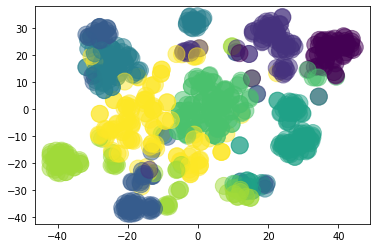

In [50]:
X = np.array(data['embediing_trf'].tolist())

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y=model.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=cluster_trf, s=290,alpha=.5)
plt.show()

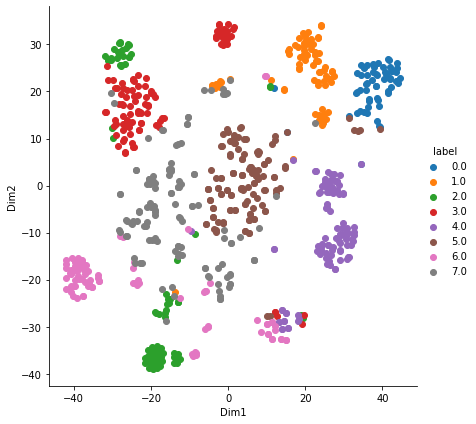

In [56]:
import numpy as np
import seaborn as sns
tnse_data=np.vstack((Y.T, cluster_trf)).T
tsne_df=pd.DataFrame(data=tnse_data, columns=('Dim1','Dim2','label'))

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

In [52]:
def distance_from_centroid_trf(row):
    # type of emb and centroid is different, hence using tolist below
    return distance_matrix([row['embediing_trf']], [row['centroid_trf'].tolist()])[0][0]

# Compute centroid distance to the data
data['distance_from_centroid_trf'] = data.apply(distance_from_centroid_trf, axis=1)

In [53]:
data.head()

,Test Case Description,Label,cleaned_text,embeddings_spaCy,cluster,centroid,distance_from_centroid,k_means_spaCy,embediing_trf,cluster_trf,centroid_trf,distance_from_centroid_trf
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago,"[0.39099964, 0.22187115, 0.05214785, 0.28463787, 0.13723904, -0.17857912, 0.70306545, -0.041043606, -0.17102624, -0.4185157, 0.09127296, -0.011548319, 0.17552137, 0.4750681, -0.3593003, 0.16939116...",10,"[0.43549743, 0.42281199, 0.11073053, 0.2677779, 0.004500212, -0.2510872, 0.5933197, -0.20490706, -0.27242213, -0.5723256, 0.056027394, -0.025331806, 0.1621705, 0.47100073, -0.3212627, 0.09180617, ...",2.654577,0,"[0.007616806, 0.005843046, 0.11240678, 0.050339803, 0.0025280218, 0.05087099, -0.008886891, -0.036157727, -0.08662188, 0.0311569, 0.01335425, -0.052121345, -0.08929149, -0.041871995, -0.033586346,...",1,"[-0.0063418048, 0.02619918, 0.028854096, 0.03329149, 0.009774283, 0.0004131784, 0.0013373792, -0.023708915, -0.014908327, 0.018002322, -0.027866563, -0.025774963, -0.026670309, 0.017449077, 0.0152...",0.905446
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow,"[0.37388843, 0.4594913, 0.06047645, 0.1588928, 1.18762255e-05, -0.24013336, 0.5891916, -0.2188668, -0.23997031, -0.56834376, -0.050958026, -0.035789233, 0.23429373, 0.4918924, -0.34998745, -0.0326...",10,"[0.43549743, 0.42281199, 0.11073053, 0.2677779, 0.004500212, -0.2510872, 0.5933197, -0.20490706, -0.27242213, -0.5723256, 0.056027394, -0.025331806, 0.1621705, 0.47100073, -0.3212627, 0.09180617, ...",1.951492,0,"[-0.061214603, -0.03637533, 0.017356902, 0.11064822, 0.034364026, 0.008444189, -0.029829586, 0.0496172, -0.008215639, -0.014838837, -0.055373635, 0.01605187, -0.072400905, 0.047417916, 0.013640420...",1,"[-0.0063418048, 0.02619918, 0.028854096, 0.03329149, 0.009774283, 0.0004131784, 0.0013373792, -0.023708915, -0.014908327, 0.018002322, -0.027866563, -0.025774963, -0.026670309, 0.017449077, 0.0152...",0.809335
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today,"[0.38037655, 0.49527752, 0.056031726, 0.17981578, 0.073269114, -0.20634057, 0.55292815, -0.26100457, -0.20759988, -0.5136793, -0.04676803, -0.038770217, 0.22752112, 0.4475448, -0.4051883, 0.076300...",10,"[0.43549743, 0.42281199, 0.11073053, 0.2677779, 0.004500212, -0.2510872, 0.5933197, -0.20490706, -0.27242213, -0.5723256, 0.056027394, -0.025331806, 0.1621705, 0.47100073, -0.3212627, 0.09180617, ...",1.956759,0,"[-0.0097305225, 0.053419128, 0.11421346, 0.08534336, -0.0020916641, -0.017286684, 0.0074873744, -0.06525992, -0.013874442, 0.0016921109, -0.036969505, -0.05427649, 0.01839362, -0.028270833, 0.0616...",1,"[-0.0063418048, 0.02619918, 0.028854096, 0.03329149, 0.009774283, 0.0004131784, 0.0013373792, -0.023708915, -0.014908327, 0.018002322, -0.027866563, -0.025774963, -0.026670309, 0.017449077, 0.0152...",0.817561
3,Is it raining in France right now?,Weather,is it raining in france right now,"[0.3607063, 0.3206141, -0.06231572, 0.49461597, -0.19429666, -0.3310444, 0.6432384, 0.16533442, -0.2383273, -0.6529438, 0.1455032, 0.089554206, 0.20580941, 0.516538, -0.5564028, 0.18595973, -0.026...",6,"[0.42366695, 0.27313936, -0.1471229, 0.2969683, -0.13046558, -0.13526769, 0.6289037, 0.046941914, -0.31098527, -0.59129417, 0.296394, -0.10164251, 0.2370117, 0.6026351, -0.4967972, 0.28011677, -0....",2.915422,10,"[0.010006898, -0.03475733, 0.08833386, -0.013573887, 0.11943102, -0.011142135, 0.029939154, -0.078966804, -0.011841778, 0.02961379, -0.06445307, -0.016232042, 0.0030896598, 0.061305318, -0.0309999...",1,"[-0.0063418048, 0.02619918, 0.028854096, 0.03329149, 0.009774283, 0.0004131784, 0.0013373792, -0.023708915, -0.014908327, 0.018002322, -0.027866563, -0.025774963, -0.026670309, 0.017449077, 0.0152...",0.806611
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week,"[0.44744533, 0.45410064, 0.10522262, 0.24095279, 

In [54]:
print(data['Label'].value_counts())
print(data['cluster_trf'].value_counts())

Device                 133
Music                  111
Calling                 89
Music_QA                71
Help                    51
Timer                   47
Screen_Reader           39
Weather                 35
Alarm                   30
AR_effect               29
Time                    26
Corona                  21
Integrity               16
Meta                    12
News                    12
Wolfarm_food            10
Assistant_messenger      8
Name: Label, dtype: int64
5    125
7    123
4     97
3     97
6     86
2     80
1     73
0     59
Name: cluster_trf, dtype: int64


### Clustering using K-means clustering

#### Validating with silhouette analysis

In [57]:
from sklearn.cluster import KMeans
# silhouette analysis
from sklearn.metrics import silhouette_score
range_n_clusters = [5, 7, 9, 11, 13, 15, 17, 19]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(list(data['embediing_trf']))
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(list(data['embediing_trf']), cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=5, the silhouette score is 0.0823497548699379
For n_clusters=7, the silhouette score is 0.10462387651205063
For n_clusters=9, the silhouette score is 0.1246723160147667
For n_clusters=11, the silhouette score is 0.14047090709209442
For n_clusters=13, the silhouette score is 0.14347296953201294
For n_clusters=15, the silhouette score is 0.14715701341629028
For n_clusters=17, the silhouette score is 0.14508013427257538
For n_clusters=19, the silhouette score is 0.15223729610443115


In [69]:
from sklearn.model_selection import GridSearchCV
parameters={
            'init' : ['k-means++', 'random'],
            'algorithm' : ["auto", "full", "elkan"],
            'max_iter' : [50,100,200,300],
            'n_init' : [10,20,30]
    
            }
clustering_model = KMeans(n_clusters=num_clusters,n_jobs=-1)
grid = GridSearchCV(clustering_model, cv=5, param_grid = parameters, scoring = 
    silhouette_score)

grid.fit(list(data['embediing_trf']))


GridSearchCV(cv=5, estimator=KMeans(n_jobs=-1),
             param_grid={'algorithm': ['auto', 'full', 'elkan'],
                         'init': ['k-means++', 'random'],
                         'max_iter': [50, 100, 200, 300],
                         'n_init': [10, 20, 30]},
             scoring=<function silhouette_score at 0x0000013F3AF2E558>)

In [70]:
print(grid.best_params_)

{'algorithm': 'auto', 'init': 'k-means++', 'max_iter': 50, 'n_init': 10}


In [58]:
# Perform kmean clustering
num_clusters = 17
clustering_model = KMeans(n_clusters=num_clusters,max_iter=50, init = 'k-means++', algorithm="auto",n_init=10)
clustering_model.fit(list(data['embediing_trf']))
cluster_assignment = clustering_model.labels_
data['k_means_clstr']=cluster_assignment
#data['k_means_centroid_trf'] = data['k_means_clstr'].apply(lambda x: kclusterer.means()[x])

In [59]:
data.tail()

,Test Case Description,Label,cleaned_text,embeddings_spaCy,cluster,centroid,distance_from_centroid,k_means_spaCy,embediing_trf,cluster_trf,centroid_trf,distance_from_centroid_trf,k_means_clstr
821,"\n From Ambient, IE not logged in: ""Hey Portal, join [room name]""\n",Assistant_messenger,from ambient ie not logged in join room name,"[0.41463464, 0.36374018, -0.14667827, 0.43960616, -0.12119066, -0.2725246, 0.5334292, 0.0058189123, -0.23578367, -0.6831135, 0.25087455, -0.17437376, -0.0022290982, 0.54769325, -0.18415178, 0.2466...",13,"[0.40919656, 0.23898178, 0.029397866, 0.30811673, -0.11719198, -0.22275431, 0.6402937, -0.19501011, -0.25465026, -0.5706986, 0.2967905, -0.021761581, 0.072129555, 0.4927791, -0.28853783, 0.2903427...",3.306431,9,"[-0.0039301314, -0.009339383, 0.033086125, 0.01946944, 0.053556602, -0.08434251, 0.077438086, -0.069221474, 0.0392521, -0.1026299, 0.012051813, -0.07979314, 0.02502016, 0.051049035, 0.061523225, 0...",2,"[-0.010426323, -0.025984108, 0.012307604, -0.020014003, -0.016180318, -0.008383215, 0.060300533, -0.021946935, 0.03756704, -0.013987595, -0.022050232, -0.004366417, -0.058551352, 0.04005572, -0.02...",1.065314,14
822,"\n ""Hey Portal, leave [room name for a room that doesn't exist] room""",Assistant_messenger,leave room name for a room that doesn t exist room,"[0.4203095, 0.31831175, 0.21167736, 0.23682919, -0.17013709, -0.14980987, 0.62621814, -0.29972002, -0.12140979, -0.6470758, 0.300654, -0.04225749, 0.1596866, 0.52103466, -0.41516915, 0.12243985, -...",11,"[0.4446704, 0.40524355, 0.16422297, 0.26095822, -0.07036028, -0.21692269, 0.67949563, -0.2044974, -0.3316126, -0.63184017, 0.25494412, 0.028538635, 0.14761718, 0.5282492, -0.3328145, 0.16856036, -...",2.592462,15,"[0.049212374, -0.022298716, -0.059738956, 0.07474709, 0.006781366, -0.06119886, 0.008825665, -0.119847104, 0.070448816, -0.0482576, 0.056465883, -0.06617751, 0.100367896, -0.018174034, -0.00029219...",7,"[-0.008703081, 0.007426243, -0.006746945, 0.012535717, 0.01805779, -0.0024959508, 0.046606947, 0.0034771555, 0.016623866, -0.0040501906, -0.0015443491, -0.03402244, -0.030369716, 0.009670872, -0.0...",0.998249,14
823,"\n ""Hey Portal, leave room""",Assistant_messenger,leave room,"[0.55409014, 0.19004144, -0.2482517, 0.357541, 0.01861034, -0.020707672, 0.5793842, 0.13547565, -0.1742876, -0.57648665, 0.24138698, 0.05631177, 0.27263764, 0.52425855, -0.50193655, 0.08103375, -0...",5,"[0.49473286, 0.31206408, -0.08520399, 0.31250924, -0.0140883345, -0.1656639, 0.6555577, -0.06287684, -0.36229593, -0.59369844, 0.238709, -0.0073507824, 0.26793697, 0.5579895, -0.3351572, 0.1725523...",3.276670,8,"[0.058012385, 0.034304004, -0.037608817, 0.048535295, 0.093555346, -0.009406522, 0.03819381, -0.05108182, 0.066583484, -0.03164529, -0.004033896, -0.038177837, 0.018316826, -0.0147712, 0.018025566...",7,"[-0.008703081, 0.007426243, -0.006746945, 0.012535717, 0.01805779, -0.0024959508, 0.046606947, 0.0034771555, 0.016623866, -0.0040501906, -0.0015443491, -0.03402244, -0.030369716, 0.009670872, -0.0...",0.853001,14
824,"\n ""Hey Portal, leave room.""",Assistant_messenger,leave room,"[0.55409014, 0.19004144, -0.2482517, 0.357541, 0.01861034, -0.020707672, 0.5793842, 0.13547565, -0.1742876, -0.57648665, 0.24138698, 0.05631177, 0.27263764, 0.52425855, -0.50193655, 0.08103375, -0...",5,"[0.49473286, 0.31206408, -0.08520399, 0.31250924, -0.0140883345, -0.1656639, 0.6555577, -0.06287684, -0.36229593, -0.59369844, 0.238709, -0.0073507824, 0.26793697, 0.5579895, -0.3351572, 0.1725523...",3.276670,8,"[0.058012385, 0.034304004, -0.037608817, 0.048535295, 0.093555346, -0.009406522, 0.03819381, -0.05108182, 0.066583484, -0.03164529, -0.004033896, -0.038177837, 0.018316826, -0.0147712, 0.018025566...",7,"[-0.008703081, 0.007426243, -0.006746945, 0.012535717, 0.01805779, -0.0024959508, 0.046606947, 0.0034771555, 0.016623866, -0.0040501906, -0.0015443491, -0.03402244, -0.030369716, 0.009670872, -0.0...",0.853001,14
825,"\n ""Hey Portal, end room.""",Assi

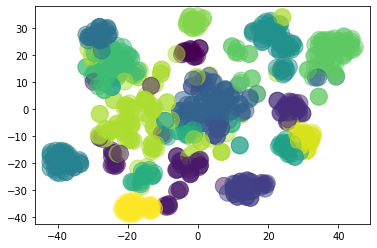

In [60]:
X = np.array(data['embediing_trf'].tolist())

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y=model.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=cluster_assignment, s=290,alpha=.5)
plt.show()

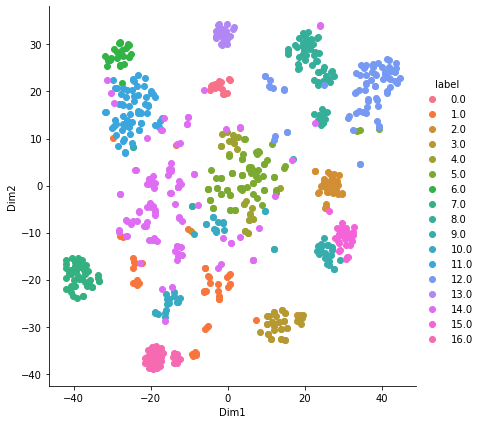

In [61]:
tnse_data=np.vstack((Y.T, cluster_assignment)).T
tsne_df=pd.DataFrame(data=tnse_data, columns=('Dim1','Dim2','label'))

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

In [62]:
print(data['Label'].value_counts())
print(data['k_means_clstr'].value_counts())

Device                 133
Music                  111
Calling                 89
Music_QA                71
Help                    51
Timer                   47
Screen_Reader           39
Weather                 35
Alarm                   30
AR_effect               29
Time                    26
Corona                  21
Integrity               16
Meta                    12
News                    12
Wolfarm_food            10
Assistant_messenger      8
Name: Label, dtype: int64
14    102
5      74
12     73
11     66
8      58
7      45
1      43
3      38
16     34
10     32
2      31
4      29
9      27
15     27
6      26
13     21
0      14
Name: k_means_clstr, dtype: int64


In [64]:
pd.set_option('display.max_rows', 500)
df1=pd.DataFrame(data.groupby(['Label','k_means_clstr'])['k_means_clstr'].count())
df1.rename(columns = {'k_means_clstr':'Count'}, inplace = True)
df1

Count
Label               k_means_clstr       
AR_effect           1                  2
                    14                27
Alarm               2                 29
                    15                 1
Assistant_messenger 14                 8
Calling             1                  1
                    6                 26
                    9                  3
                    11                49
                    14                10
Corona              13                21
Device              0                  2
                    1                 33
                    2                  1
                    5                  3
                    7                 45
                    10                18
                    11                12
                    14                19
Help                1                  1
                    2                  1
                    3                 38
                    14                11
Integrity           11                 4
                    14                12
Meta                5                  2
                    8                  1
                    9                  1
                    10                 3
                    11                 1
                    14                 4
Music               1                  1
                    4                 29
                    5                 60
                    9                  2
                    10                11
                    14                 8
Music_QA            5                  9
                    12                62
News                0                 12
Screen_Reader       1                  5
                    16                34
Time                8                 24
                    12                 1
                    14                 1
Timer               9                 21
                    15                26
Weather             8                 33
                    14                 2
Wolfarm_food        12                10

In [63]:
pd.set_option('display.max_rows', 500)
data[data['k_means_clstr']==5][['cleaned_text','Label','k_means_clstr']]

,cleaned_text,Label,k_means_clstr
274,open iheartradio,Device,5
278,open pandora,Device,5
281,open spotify,Device,5
364,play why won t you date me on iheartradio,Music,5
378,play this past weekend,Music,5
380,play the weeds,Music,5
424,play iheartradio,Music,5
426,play some music,Music,5
428,resume music,Music,5
430,resume playing the song,Music,5
